## carichiamo pacchetti

In [ ]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# csv per applicazione dei modelli
df = pd.read_csv('/content/drive/MyDrive/data/modelling_data1.csv')

r = df[df['label']==1]

## Term Frequency

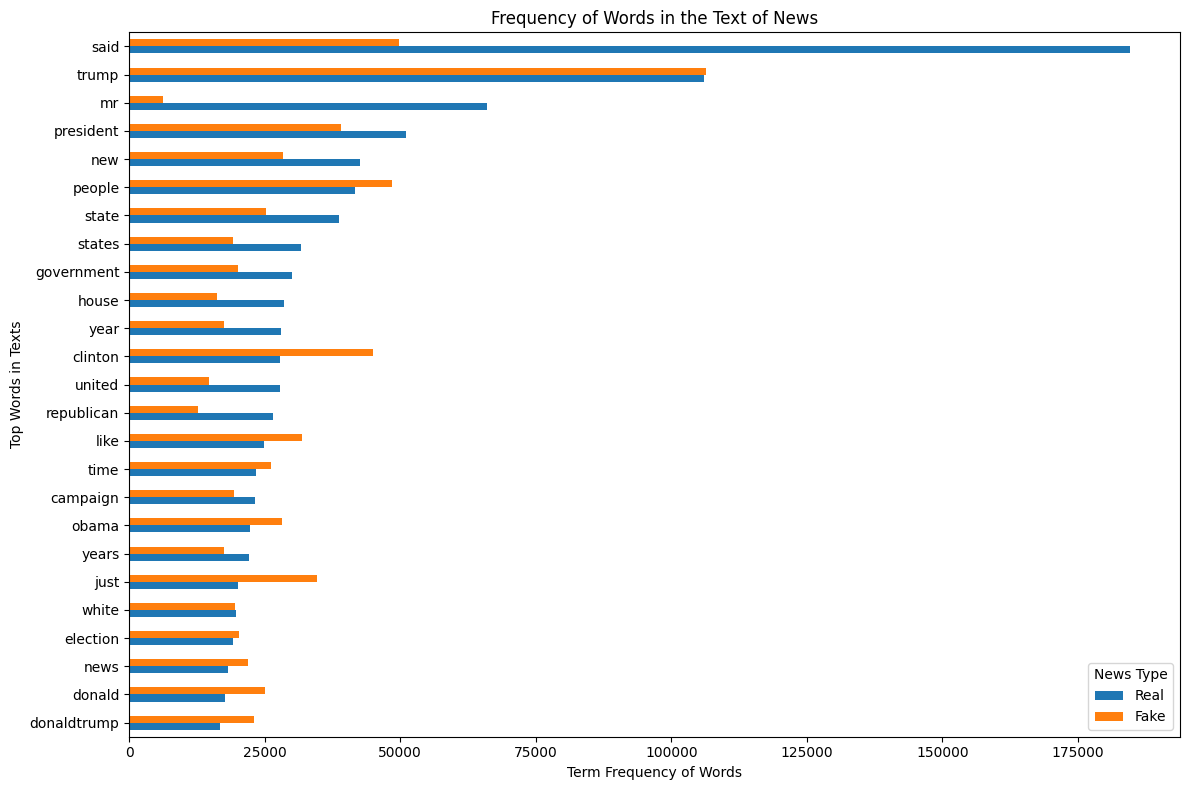

In [ ]:
# df: DataFrame con colonne 'text' e 'label' (0/1 o 'real'/'fake')
df = pd.read_csv("prdataset.csv")  #csv precedentemente lavorato a partire dal dataset originario

# mappa label
lab = df["label"].astype(str).str.lower().map({"0":"Real","1":"Fake","real":"Real","fake":"Fake"})
df = df.assign(NewsType=lab)

# vettorizzazione: unigrammi + bigrammi, stopwords rimosse
vect = CountVectorizer(stop_words="english",
                       ngram_range=(1,2),
                       token_pattern=r"[a-zA-Z']{2,}",
                       min_df=5)  # alza/abbassa se vuoi
X = vect.fit_transform(df["text"].astype(str))

# frequenze per classe
real_mask = df["NewsType"].eq("Real").values
fake_mask = df["NewsType"].eq("Fake").values
freq_real = np.asarray(X[real_mask].sum(axis=0)).ravel()
freq_fake = np.asarray(X[fake_mask].sum(axis=0)).ravel()
terms = np.array(vect.get_feature_names_out())

# scegli i top N per somma totale
top_n = 25
total = freq_real + freq_fake
idx = np.argsort(total)[::-1][:top_n]
plot_df = pd.DataFrame({
    "term": terms[idx],
    "Real": freq_real[idx],
    "Fake": freq_fake[idx]
})

# “unisci” visivamente i bigrammi (opzionale)
plot_df["term"] = plot_df["term"].str.replace(" ", "", regex=False)

# plot
plot_df = plot_df.sort_values("Real", ascending=True)  # o per 'total'
ax = plot_df.set_index("term")[["Real","Fake"]].plot(kind="barh", figsize=(12,8))
ax.set_title("Frequency of Words in the Text of News")
ax.set_xlabel("Term Frequency of Words")
ax.set_ylabel("Top Words in Texts")
ax.legend(title="News Type")
plt.tight_layout()
plt.show()

## Wordcloud

In [ ]:
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords

real_news_text = " ".join(df[df['NewsType'] == 'Real']['text'].dropna())
fake_news_text = " ".join(df[df['NewsType'] == 'Fake']['text'].dropna())

stopwords = set(STOPWORDS)
# Add more specific stopwords based on common terms from earlier analysis
stopwords.update(["trump", "said", "new", "like", "people", "time", "year", "just", "state", "states", "government", "house", "united", "republican", "campaign", "obama", "years", "white", "election", "news", "clinton", "would", "one", "get", "don", "say", "told", "also", "mr", "president"])

wordcloud_real = WordCloud(stopwords=stopwords, max_font_size=80, max_words=150, background_color="white").generate(real_news_text)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud_real, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Real News")
plt.show()

wordcloud_fake = WordCloud(stopwords=stopwords, max_font_size=80, max_words=150, background_color="white").generate(fake_news_text)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud_fake, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Fake News )")
plt.show()

In [ ]:
# rappresentazione t-sne e PCA
df_n = df.drop('label', axis=1)
df_matrix = np.array(df_n)
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

In [ ]:
# PCA
X = (df_matrix - np.mean(df_matrix, axis=0)) / np.std(df_matrix, axis=0)
pca = PCA(n_components=2, whiten=True)
pca.fit(X)


PCA(n_components=2, whiten=True)

In [ ]:
pca_result = pca.fit_transform(X)
pca.explained_variance_ratio_ # la prima spiega praticamente tutta la varianza


array([0.08051764, 0.07795786])

In [ ]:
pca_d = pd.DataFrame()
pca_d['y'] = df['label']
pca_d['pca-one'] = pca_result[:,0]
pca_d['pca-two'] = pca_result[:,1]

## Carichiamo train e test

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/train_mod.csv').drop(columns='index')
df_test  = pd.read_csv('/content/drive/MyDrive/test_mod.csv').drop(columns='index')

## Distribuzione Real e Fake news

Train: 53,517  Test: 17,840  Totale: 71,357
Conteggi complessivi per label (0=real, 1=fake):
label
0    35027
1    36330
Name: count, dtype: int64


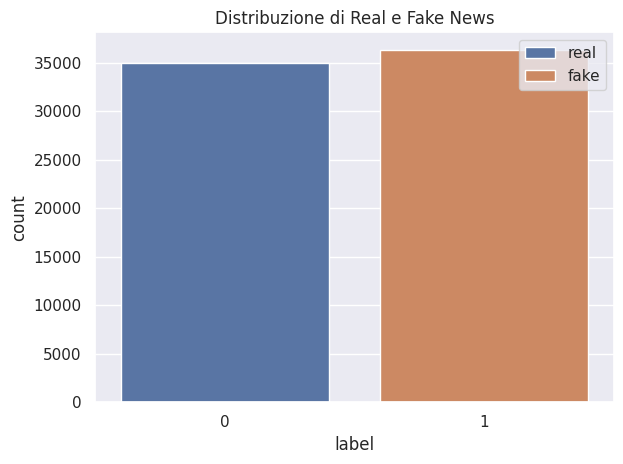

In [ ]:
import seaborn as sns

def coerce_labels(s: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(s):
        return s.astype(int)
    s = s.astype(str).str.strip().str.upper()
    s = s.replace({"FAKE": "1", "REAL": "0"})
    return pd.to_numeric(s, errors="coerce").fillna(0).astype(int)

df_train = df_train.copy()
df_test  = df_test.copy()
df_train["label"] = coerce_labels(df_train["label"])
df_test["label"]  = coerce_labels(df_test["label"])


df_all = pd.concat([df_train[["label"]], df_test[["label"]]], ignore_index=True)


print(f"Train: {len(df_train):,}  Test: {len(df_test):,}  Totale: {len(df_all):,}")
print("Conteggi complessivi per label (0=real, 1=fake):")
print(df_all["label"].value_counts().sort_index())


df_all["label_str"] = df_all["label"].map({1: "fake", 0: "real"})

sns.set_theme(style="darkgrid")
ax = sns.countplot(data=df_all, x="label", hue="label_str", order=[0, 1], dodge=False)
ax.set_title("Distribuzione di Real e Fake News")
ax.set_xlabel("label")
ax.set_ylabel("count")
ax.legend(title="", loc="upper right")

plt.tight_layout()
plt.show()

## Testi inferiori a 250 parole

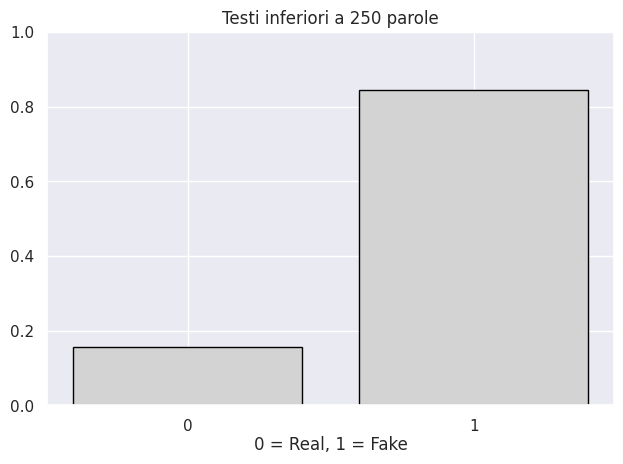

In [ ]:
import re

def coerce_labels(s: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(s):
        return s.astype(int)
    s = s.astype(str).str.strip().str.upper().replace({"FAKE": "1", "REAL": "0"})
    return pd.to_numeric(s, errors="coerce").fillna(0).astype(int)


def find_text_or_length_col(df: pd.DataFrame):

    preferred = [
        "text","body","content","article","news","document","full_text",
        "clean_text","text_clean","text_processed","message","story",
        "title","headline","abstract","description","desc"
    ]
    lower = {c.lower(): c for c in df.columns}
    for k in preferred:
        if k in lower:
            return ("text", lower[k])


    obj_cols = [c for c in df.columns
                if (pd.api.types.is_object_dtype(df[c]) or pd.api.types.is_string_dtype(df[c]))]
    if obj_cols:
        means = {c: df[c].astype(str).str.len().replace([np.inf, -np.inf], np.nan).dropna().mean()
                 for c in obj_cols}

        if len(means) and max(means.values()) > 20:
            best = max(means, key=means.get)
            return ("text", best)

    len_candidates = [c for c in df.columns
                      if re.search(r'(word|words|token|tokens|len|length)', c.lower())
                      and pd.api.types.is_numeric_dtype(df[c])]
    if len(len_candidates):
        best = max(len_candidates, key=lambda c: df[c].astype(float).mean())
        return ("len", best)

    return (None, None)


df_all = pd.concat([df_train, df_test], ignore_index=True).copy()
df_all["label"] = coerce_labels(df_all["label"])

kind, col = find_text_or_length_col(df_all)
if kind is None:
    cols = ", ".join(df_all.columns.astype(str).tolist())
    raise RuntimeError(
        "Non ho trovato né una colonna di testo né una colonna di lunghezza.\n"
        "Specifica il nome della colonna manualmente (es. TEXT_COL='titolo' oppure LENGTH_COL='word_count').\n"
        f"Colonne disponibili: {cols}"
    )


# calcola word_count
if kind == "text":
    df_all[col] = df_all[col].fillna("").astype(str)
    df_all["word_count"] = df_all[col].str.split().str.len()
else:  # kind == "len"
    df_all["word_count"] = pd.to_numeric(df_all[col], errors="coerce").fillna(0).astype(int)

#  filtra < 250 parole
short = df_all[df_all["word_count"] < 250].copy()
props = short["label"].value_counts(normalize=True).sort_index().reindex([0, 1], fill_value=0)


fig, ax = plt.subplots()
ax.bar(["0", "1"], props.values, color="lightgray", edgecolor="black")
ax.set_ylim(0, 1)
ax.set_title("Testi inferiori a 250 parole")
ax.set_xlabel("")
ax.set_ylabel("")
ax.text(0.5, -0.12, "0 = Real, 1 = Fake", ha="center", transform=ax.transAxes)
plt.tight_layout()
plt.show()

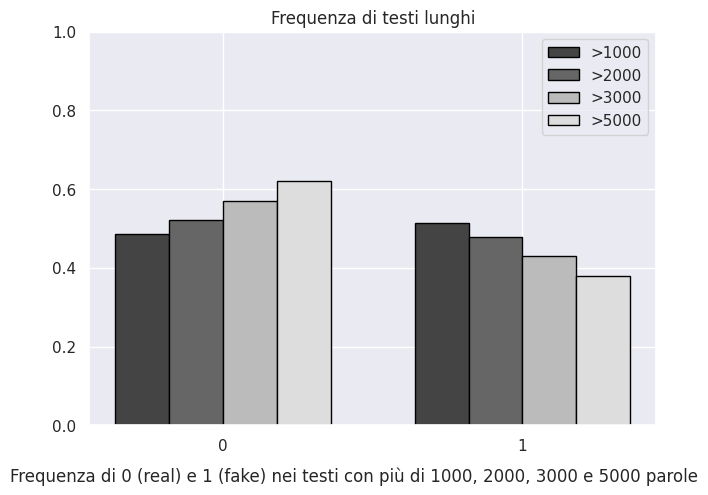

In [ ]:
def coerce_labels(s: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(s):
        return s.astype(int)
    s = s.astype(str).str.strip().str.upper().map({"FAKE": 1, "REAL": 0})
    return s.fillna(pd.to_numeric(s, errors="coerce")).fillna(0).astype(int)

def get_word_count(df: pd.DataFrame) -> pd.Series:

    for c in df.columns:
        cl = c.lower()
        if cl in {"word_count","num_words","n_words","tokens","length","len"} and \
           pd.api.types.is_numeric_dtype(df[c]):
            return pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

    for c in ["text","content","body","article","news","document",
              "full_text","clean_text","message","story","title","headline"]:
        if c in df.columns:
            return df[c].fillna("").astype(str).str.split().str.len()

    obj_cols = [c for c in df.columns if df[c].dtype == "object"]
    if obj_cols:
        best = max(obj_cols, key=lambda c: df[c].astype(str).str.len().mean())
        return df[best].fillna("").astype(str).str.split().str.len()
    raise ValueError("Nessuna colonna di testo o di lunghezza trovata.")


df_all = pd.concat([df_train, df_test], ignore_index=True).copy()
df_all["label"] = coerce_labels(df_all["label"])
df_all["word_count"] = get_word_count(df_all)

# Calcola le frequenze per soglie di “testi lunghi”
thresholds = [1000, 2000, 3000, 5000]
res = pd.DataFrame({"label": [0, 1]})
for thr in thresholds:
    props = (
        df_all.loc[df_all["word_count"] > thr, "label"]
        .value_counts(normalize=True)
        .reindex([0, 1], fill_value=0)
    )
    res[f">{thr}"] = props.values


x = np.arange(len(res["label"]))
width = 0.18
colors = ["#444444", "#666666", "#BBBBBB", "#DDDDDD"]

fig, ax = plt.subplots()
for i, thr in enumerate(thresholds):
    ax.bar(
        x + (i - (len(thresholds) - 1) / 2) * width,
        res[f">{thr}"],
        width,
        label=f">{thr}",
        color=colors[i],
        edgecolor="black",
    )

ax.set_xticks(x)
ax.set_xticklabels(res["label"].astype(str))
ax.set_ylim(0, 1)
ax.set_title("Frequenza di testi lunghi")
ax.legend(title="")

fig.text(
    0.5,
    -0.02,
    "Frequenza di 0 (real) e 1 (fake) nei testi con più di 1000, 2000, 3000 e 5000 parole",
    ha="center",
)
plt.tight_layout()
plt.show()

→ Userò 'perc11' come ratio parole lunghe. (Candidati: ['perc11'])


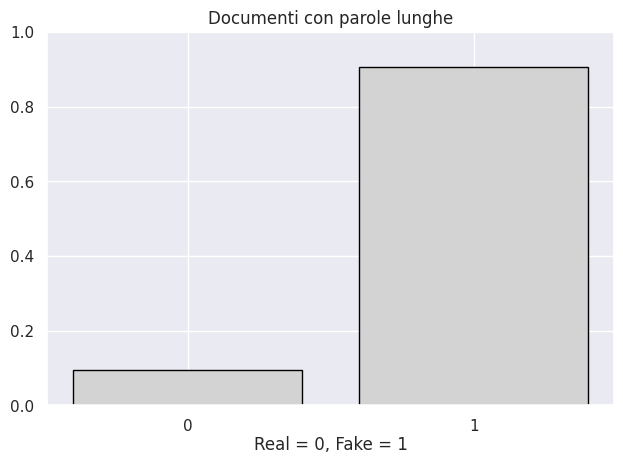

→ Userò 'quotes' come flag citazioni (0/1). (Candidati: ['quotes'])


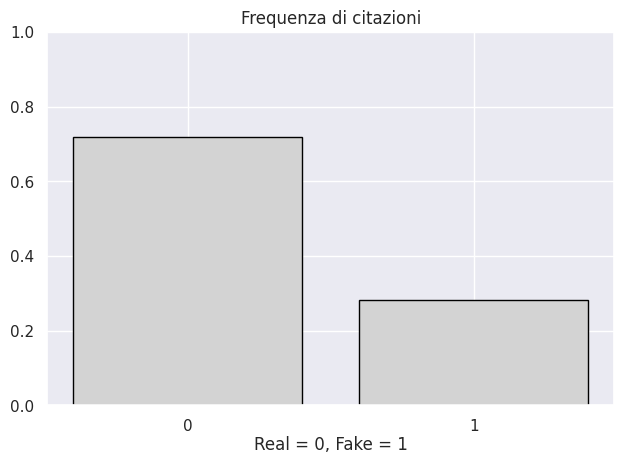


Prime 30 colonne e dtype:
                      col    dtype
0                   index    int64
1                   label    int64
2                  length    int64
3                   perc5  float64
4                  perc11  float64
5                av_words  float64
6                   punct    int64
7                  quotes    int64
8                    fear  float64
9                   anger  float64
10                  trust  float64
11               surprise  float64
12               positive  float64
13               negative  float64
14                sadness  float64
15                disgust  float64
16                    joy  float64
17           anticipation  float64
18         PoliticaEstera  float64
19              Attualita  float64
20          CampagnaTrump  float64
21                 Russia  float64
22           Repubblicani  float64
23                Arresti  float64
24  InvestigazioneClinton  float64
25                Societa  float64
26                  trump  f

In [ ]:
def coerce_labels(s: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(s): return s.astype(int)
    s = s.astype(str).str.strip().str.upper().replace({"FAKE": "1", "REAL": "0"})
    return pd.to_numeric(s, errors="coerce").fillna(0).astype(int)

def find_numeric_cols(df, keywords):
    kw = [k.lower() for k in keywords]
    out = []
    for c in df.columns:
        cl = c.lower()
        if any(k in cl for k in kw) and pd.api.types.is_numeric_dtype(df[c]):
            out.append(c)
    return out

def pick_first(cands, label):
    if cands:
        print(f"→ Userò '{cands[0]}' come {label}. (Candidati: {cands})")
        return cands[0]
    print(f"Nessuna colonna identificata per {label}.")
    return None

# Unisci e normalizza
df_all = pd.concat([df_train, df_test], ignore_index=True).copy()
df_all["label"] = coerce_labels(df_all["label"])

ratio_cands = find_numeric_cols(
    df_all,
    ["long_ratio", "perc_long", "share_long", "prop_long",
     "gt11", "11", "len_gt_11", "words_gt_11", "longwords_ratio", "over11"]
)
ratio_col = pick_first(ratio_cands, "ratio parole lunghe")


long_count_cands = find_numeric_cols(df_all, ["n_long", "long_words", "words_gt_11", "gt11"])
total_count_cands = find_numeric_cols(df_all, ["word_count", "n_words", "num_words", "tokens"])
long_count_col = None
total_count_col = None
if ratio_col is None:
    long_count_col = pick_first(long_count_cands, "conteggio parole lunghe")
    total_count_col = pick_first(total_count_cands, "conteggio totale parole")

if ratio_col is not None:
    long_ratio = pd.to_numeric(df_all[ratio_col], errors="coerce")
elif long_count_col and total_count_col:
    long_ratio = pd.to_numeric(df_all[long_count_col], errors="coerce") / \
                 pd.to_numeric(df_all[total_count_col], errors="coerce").replace(0, np.nan)
else:
    long_ratio = None

# Plot 1: Documenti con >20% di parole lunghe
if long_ratio is not None:
    mask_long = long_ratio > 0.20
    props_long = df_all.loc[mask_long, "label"].value_counts(normalize=True) \
                     .reindex([0, 1], fill_value=0)
    fig, ax = plt.subplots()
    ax.bar(["0", "1"], props_long.values, color="lightgray", edgecolor="black")
    ax.set_ylim(0, 1)
    ax.set_title("Documenti con parole lunghe")
    ax.text(0.5, -0.12, "Real = 0, Fake = 1", ha="center", transform=ax.transAxes)
    plt.tight_layout()
    plt.show()
else:
    print("Impossibile creare il grafico 'Documenti con parole lunghe'. "
          "Non ho trovato né una colonna ratio né (n_long, n_words).")

# 2) ---- CITAZIONI ----

quote_flag_cands = find_numeric_cols(df_all, ["has_quote", "quote_flag", "cit", "quote", "virgo"])
quote_flag_col = pick_first(quote_flag_cands, "flag citazioni (0/1)")

# b) in alternativa: conteggio citazioni > 0
quote_count_cands = find_numeric_cols(df_all, ["quote_count", "n_quotes", "num_quotes", "cit_count", "virgolette"])
quote_count_col = None if quote_flag_col else pick_first(quote_count_cands, "conteggio citazioni")

if quote_flag_col:
    mask_quote = df_all[quote_flag_col] > 0
elif quote_count_col:
    mask_quote = df_all[quote_count_col] > 0
else:
    mask_quote = None

# Plot 2: Frequenza di citazioni
if mask_quote is not None and mask_quote.any():
    props_quote = df_all.loc[mask_quote, "label"].value_counts(normalize=True) \
                        .reindex([0, 1], fill_value=0)
    fig, ax = plt.subplots()
    ax.bar(["0", "1"], props_quote.values, color="lightgray", edgecolor="black")
    ax.set_ylim(0, 1)
    ax.set_title("Frequenza di citazioni")
    ax.text(0.5, -0.12, "Real = 0, Fake = 1", ha="center", transform=ax.transAxes)
    plt.tight_layout()
    plt.show()
else:
    print("Impossibile creare il grafico 'Frequenza di citazioni'. "
          "Non ho trovato né un flag 0/1 né un conteggio di citazioni > 0.")


print("\nPrime 30 colonne e dtype:")
print(pd.DataFrame({"col": df_all.columns[:30], "dtype": [df_all[c].dtype for c in df_all.columns[:30]]}))

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# normalizza label (0=real, 1=fake)
if "label" not in df_all.columns:
    raise ValueError("Manca la colonna 'label'.")
lab = df_all["label"]
if not pd.api.types.is_numeric_dtype(lab):
    lab = lab.astype(str).str.strip().str.upper().replace({"FAKE":"1","REAL":"0"})
    lab = pd.to_numeric(lab, errors="coerce").fillna(0).astype(int)


def words_list(t: str):
    return re.findall(r"\b\w+\b", t, flags=re.UNICODE)

def word_count(s: pd.Series):
    return s.str.split().str.len()

def avg_word_len(s: pd.Series):
    def f(t):
        ws = words_list(t)
        return 0.0 if not ws else np.mean([len(w) for w in ws])
    return s.apply(f)

def punct_ratio(s: pd.Series):
    # rapporto punteggiatura/caratteri
    return s.apply(lambda t: (len(re.findall(r"[^\w\s]", t)) / max(len(t),1)))

def quotes_count(s: pd.Series):
    return s.str.count(r'["“”«»„‟‹›‘’]')

def share_words_ge(s: pd.Series, k: int):
    def f(t):
        ws = words_list(t)
        return 0.0 if not ws else np.mean([len(w) >= k for w in ws])
    return s.apply(f)

# se c'è il testo, calcola le colonne mancanti
if "text" in df_all.columns:
    txt = df_all["text"].fillna("").astype(str)
    df_all.setdefault("length",   word_count(txt))
    df_all.setdefault("av_words", avg_word_len(txt))
    df_all.setdefault("punct",    punct_ratio(txt))
    df_all.setdefault("quotes",   quotes_count(txt))
    df_all.setdefault("perc11",   share_words_ge(txt, 12))  # >11 ⇒ >=12
    df_all.setdefault("perc5",    share_words_ge(txt, 6))   # >5  ⇒ >=6

# Seleziona le feature disponibili ===
feat_order = ["length", "av_words", "punct", "quotes", "perc5", "perc11"]
features = [c for c in feat_order if c in df_all.columns]
if len(features) < 2:
    raise ValueError("Servono almeno due feature tra: " + ", ".join(feat_order))

X = df_all[features].astype(float)
y = lab.values

# PCA sui dati standardizzati
Xz = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
scores = pca.fit_transform(Xz)              # coordinate dei punti (PC1, PC2)
# direzioni delle variabili
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)  # shape (p,2)


scale = 0.85 * min(scores[:,0].std(), scores[:,1].std())

# Plot
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(8,6))

# punti: 0=real (teal), 1=fake (salmon)
mask0 = (y == 0)
mask1 = (y == 1)
ax.scatter(scores[mask1,0], scores[mask1,1], s=18, c="#fc8d62", label="fake", alpha=0.7)
ax.scatter(scores[mask0,0], scores[mask0,1], s=18, c="#66c2a5", label="real", alpha=0.7)

# frecce + etichette rosse
for i, var in enumerate(features):
    ax.arrow(0, 0, loadings[i,0]*scale, loadings[i,1]*scale,
             color="red", alpha=0.9, head_width=0.002, length_includes_head=True)
    ax.text(loadings[i,0]*scale*1.05, loadings[i,1]*scale*1.05, var,
            color="red", fontsize=9)

# etichette assi con % varianza
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
ax.set_title("Analisi delle componenti principali (caratteristiche sintattiche)")
ax.legend(title="label", frameon=True)
plt.tight_layout()
plt.show()

## Split train e test set per analisi con vari modelli

In [ ]:
y_train=df_train['label']
X_train=df_train.loc[:,df_train.columns!='label']
y_test=df_test['label']
X_test=df_test.loc[:,df_test.columns!='label']

In [ ]:
ss_train =StandardScaler()
X_train =pd.DataFrame(ss_train.fit_transform(X_train))
ss_test =StandardScaler()
X_test =pd.DataFrame(ss_test.fit_transform(X_test))

In [ ]:
random.seed(123)
rnd =random.sample(range(53517),21000)
X_train1 =X_train.loc[rnd]
y_train1 =y_train.loc[rnd]
X_validation =X_train.drop(rnd)
y_validation =y_train.drop(rnd)


## Applicazione modelli

## Regressione logistica


In [ ]:
model=LogisticRegression()
glm =model.fit(X_train,y_train)
predictions_glm = glm.predict(X_test) # Add this line to make predictions
cm =confusion_matrix(y_test,predictions_glm)
f1_score(y_test,predictions_glm)
accuracy_score(y_test,predictions_glm)

0.8704596412556054

Matrice di confusione:
 [[7516 1246]
 [1065 8013]]
F1-score: 0.8739706604133719
Accuracy: 0.8704596412556054


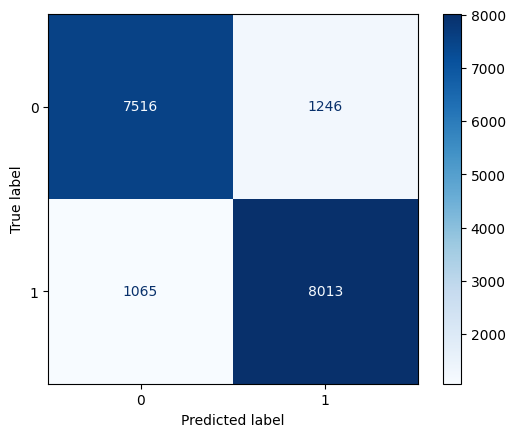

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predictions_glm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Metriche
f1 = f1_score(y_test, predictions_glm)
acc = accuracy_score(y_test, predictions_glm)

print("Matrice di confusione:\n", cm)
print("F1-score:", f1)
print("Accuracy:", acc)

## Analisi discriminante


In [ ]:
LDA =LinearDiscriminantAnalysis()
lda =LDA.fit(X_train,y_train)
QDA =QuadraticDiscriminantAnalysis()
qda =QDA.fit(X_train,y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


In [ ]:
pred_lda =lda.predict(X_test)
pred_qda =qda.predict(X_test)

In [ ]:
cm_lda =confusion_matrix(y_test,pred_lda)
cm_qda =confusion_matrix(y_test,pred_qda)
accuracy_score(y_test,pred_lda)
accuracy_score(y_test,pred_qda)
f1_score(y_test,pred_lda)
f1_score(y_test,pred_qda)

0.7362863765130054

## matrice di confusione LDA

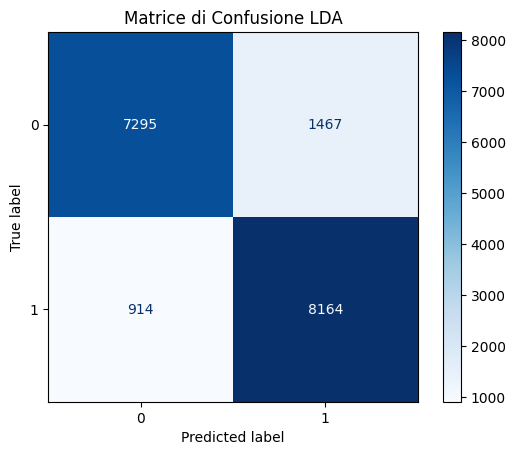

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

disp_lda = ConfusionMatrixDisplay(confusion_matrix=cm_lda)
disp_lda.plot(cmap="Blues")
plt.title("Matrice di Confusione LDA")
plt.show()

## matrice di confusione QDA

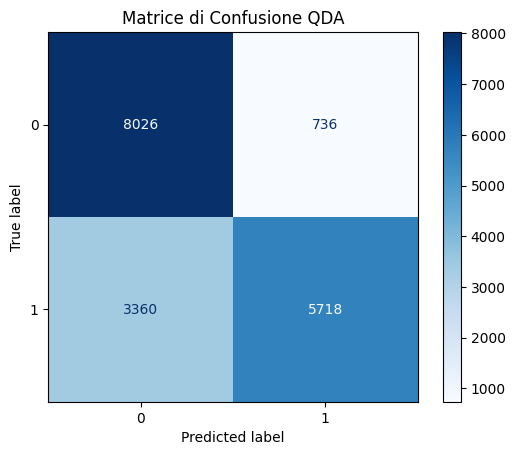

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

disp_qda = ConfusionMatrixDisplay(confusion_matrix=cm_qda)
disp_qda.plot(cmap="Blues")
plt.title("Matrice di Confusione QDA")
plt.show()

## Albero di classificazione

In [ ]:
dtree = DecisionTreeClassifier(criterion='entropy',max_depth=14)
d_fit = dtree.fit(X_train,y_train)
pred_tree = d_fit.predict(X_test)
accuracy_score(y_test,pred_tree)
f1_score(y_test,pred_tree)
cm = confusion_matrix(y_test,pred_tree)

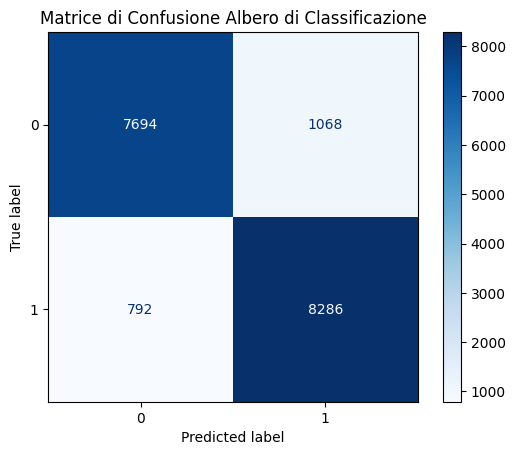

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matrice di Confusione Albero di Classificazione")
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(ccp_alphas, test_scores, marker='o', drawstyle="steps-post")
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.title("Accuracy sul Test Set vs alpha per Decision Tree")
plt.grid(True)
plt.show()

In [ ]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

# potatura
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
  clf = DecisionTreeClassifier(random_state=0,ccp_alpha=ccp_alpha)
  clf.fit(X_train,y_train)
  clfs.append(clf)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

test_scores =[clf.score(X_test,y_test) for clf in clfs]

plt.figure(figsize=(8, 6))
plt.plot(ccp_alphas, test_scores, marker='o', drawstyle="steps-post")
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.title("Accuracy sul Test Set vs alpha per Decision Tree")
plt.grid(True)
plt.show()

ind = test_scores.index(max(test_scores))
best_alpha = ccp_alphas[ind]
best_depth = clfs[ind].tree_.max_depth

print(f"Il valore di alpha dove lo score del test set è maggiore è: {best_alpha:.5f}")
print(f"La massima profondità raggiunta dell'albero con questo alpha è: {best_depth}")

## confronto indici Gini vs Entropia per alberi classificazione

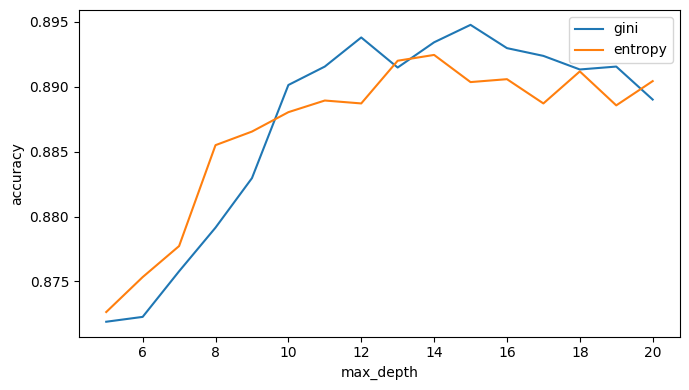

Gini: 15
Entropy: 14


In [ ]:
y = df_train['label']
X = df_train.drop(columns='label')

# split train/val (il test rimane per la valutazione finale)
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y)

# scaling (non serve agli alberi, ma se vogliamo tenerlo: usa lo stesso scaler)
scaler = StandardScaler()
X_tr  = scaler.fit_transform(X_tr)
X_val = scaler.transform(X_val)

# --- sweep su max_depth
depths = list(range(5, 21))
acc_gini, acc_entropy = [], []

for d in depths:
    # Gini
    clf_g = DecisionTreeClassifier(criterion='gini', max_depth=d, random_state=0)
    clf_g.fit(X_tr, y_tr)
    acc_gini.append(accuracy_score(y_val, clf_g.predict(X_val)))

    # Entropy
    clf_e = DecisionTreeClassifier(criterion='entropy', max_depth=d, random_state=0)
    clf_e.fit(X_tr, y_tr)
    acc_entropy.append(accuracy_score(y_val, clf_e.predict(X_val)))

# --- grafico
plt.figure(figsize=(7,4))
plt.plot(depths, acc_gini, label='gini')
plt.plot(depths, acc_entropy, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.tight_layout()
plt.show()


best_gini_depth = depths[int(np.argmax(acc_gini))]
best_entropy_depth = depths[int(np.argmax(acc_entropy))]
print("Gini:", best_gini_depth)
print("Entropy:", best_entropy_depth)


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_grid =RandomForestClassifier(max_depth=14)
param_grid ={
'n_estimators':np.linspace(1000,3000,11,dtype=int),
'max_features':[1,2,4,6,7,10,15,20],
'criterion': ['gini','entropy'],
'bootstrap': [True,False]
}
grid_rf_search=GridSearchCV(estimator=rf_grid,param_grid=param_grid,
n_jobs =2,verbose=2)
grid_rf =grid_rf_search.fit(X_train1,y_train1)
best_rf_grid =grid_rf_search.best_estimator_
pred_bestrf =best_rf_grid.predict(X_validation)
accuracy_score(y_validation,pred_bestrf)
rf =RandomForestClassifier(n_estimators=2400,criterion='entropy',
bootstrap=True,max_depth=14,max_features=20)
rf_fit =rf.fit(X_train1,y_train1)
pred_rf =rf_fit.predict(X_test)
cm =confusion_matrix(y_test,pred_rf)
accuracy_score(y_test,pred_rf)
f1_score(y_test,pred_rf)
importances_rf=rf.feature_importances_

## Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


gbc=GradientBoostingClassifier(max_depth=14)
param_grid_gbc={
'n_estimators':np.linspace(1000,3000,11,dtype=int),
'learning_rate':np.linspace(0,1,11)}
grid_gbc_search=GridSearchCV(estimator=gbc,param_grid=param_grid_gbc,
verbose=2)
grid_gbc =grid_gbc_search.fit(X_train1,y_train1)
best_gbc =grid_gbc.best_estimator_
pred_bestgbc =best_gbc.predict(X_validation)
accuracy_score(y_validation,pred_bestgbc)
gbc =GradientBoostingClassifier(n_estimators=1600,learning_rate=0.4,
max_depth=14)
gbc_fit =gbc.fit(X_train1,y_train1)
pred_gbc =gbc_fit.predict(X_test)
accuracy_score(y_test,pred_gbc)
cm =confusion_matrix(y_test,pred_gbc)

## Curva ROC

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


if 'glm' not in globals():
    print("Modello Logistic Regression (glm) non trovato.")
if 'd_fit' not in globals():
    print("Modello Decision Tree (d_fit) non trovato.")
if 'rf_fit' not in globals():
    print("Modello Random Forest (rf_fit) non trovato.")
if 'gbc_fit' not in globals():
    print("Modello Gradient Boosting (gbc_fit) non trovato.")
if 'X_test' not in globals() or 'y_test' not in globals():
     print("Dati di test (X_test, y_test) non trovati.")
     exit()


plt.figure(figsize=(10, 8))

# Logistic Regression ROC
if 'glm' in globals():
    y_pred_proba_glm = glm.predict_proba(X_test)[:, 1]
    fpr_glm, tpr_glm, _ = roc_curve(y_test, y_pred_proba_glm)
    roc_auc_glm = auc(fpr_glm, tpr_glm)
    plt.plot(fpr_glm, tpr_glm, label=f'Logistic Regression (AUC = {roc_auc_glm:.2f})')

# Decision Tree ROC
if 'd_fit' in globals():
    y_pred_proba_tree = d_fit.predict_proba(X_test)[:, 1]
    fpr_tree, tpr_tree, _ = roc_curve(y_test, y_pred_proba_tree)
    roc_auc_tree = auc(fpr_tree, tpr_tree)
    plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC = {roc_auc_tree:.2f})')

# Random Forest ROC
if 'rf_fit' in globals():
    y_pred_proba_rf = rf_fit.predict_proba(X_test)[:, 1]
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

# Gradient Boosting ROC
if 'gbc_fit' in globals():
    y_pred_proba_gbc = gbc_fit.predict_proba(X_test)[:, 1]
    fpr_gbc, tpr_gbc, _ = roc_curve(y_test, y_pred_proba_gbc)
    roc_auc_gbc = auc(fpr_gbc, tpr_gbc)
    plt.plot(fpr_gbc, tpr_gbc, label=f'Gradient Boosting (AUC = {roc_auc_gbc:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Applicazione di BERT

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import gc

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.python.client import device_lib
from transformers import AutoTokenizer, TFBertModel

SEED = 10

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/dataset.csv')
df.dropna(subset = ['text', 'title'], inplace = True)
df['text'] = df['title'] + ' ' + df['text']

X = df['text']
y = df['label']

In [ ]:
df['num_words'] = df['text'].apply(lambda x: len(x.split()))

In [ ]:
# LSTM
MAX_LEN = 100

def get_model():
    dropout_rate = 0.2

    input_ids = Input(shape = (MAX_LEN,), dtype = tf.int32, name = 'input_ids')
    input_mask = Input(shape = (MAX_LEN,), dtype = tf.int32, name = 'input_mask')

    embeddings = bert([input_ids, input_mask])[1] #pooler output
    print(embeddings)

    out = Dropout(0.2)(embeddings)

    #64 units dense layer
    out = Dense(64,activation = 'relu')(out)
    out = Dropout(0.2)(out)

    y = Dense(1,activation = 'sigmoid')(out)

    model = Model(inputs=[input_ids, input_mask], outputs=y)
    model.layers[2].trainable = True

    #ADAM
    optimizer = Adam(learning_rate=1e-05, epsilon=1e-08,decay=0.01,clipnorm=1.0)

    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')

    return model

# funzione tokenizer
def get_tokens(X):

    X = tokenizer(
                text = list(X),
                add_special_tokens = True,
                max_length = MAX_LEN,
                truncation = True,
                padding = True,
                return_tensors = 'tf',
                return_token_type_ids = False,
                return_attention_mask = True,
                verbose = True
                )

    return X

In [ ]:
#plot con Bert
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased', cache_dir='./bert_cache')

model = get_model()
tf.keras.utils.plot_model(model)

In [ ]:
#split train e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = SEED)

In [ ]:
X_train_seq = get_tokens(X_train)
X_test_seq = get_tokens(X_test)

history = model.fit(x = {'input_ids':X_train_seq['input_ids'],'input_mask':X_train_seq['attention_mask']},
                    y = y_train, epochs=10,
                    validation_split = 0.2, batch_size = 32, callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

In [ ]:
#plottiamo train/validation loss e accuracy
def plot_graphs(history, metric):

    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [ ]:
#predict test set labels
yhat =  np.where(model.predict({'input_ids':X_test_seq['input_ids'],'input_mask':X_test_seq['attention_mask']}) >=0.5,1,0)

In [ ]:
print(classification_report(y_test,yhat))

In [ ]:
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test,yhat), annot=True,
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')